# Organizing, Subsetting and Processing Data

Now that you've successfully downloaded the GRACE and GLDAS data, you will need to read in and process the data to get groundwater anamoly estimates. Both datasets have raw data contained in .nc or .nc4 files. These are files for storing multi-dimensional data--in our case, the key dimensions we are interested in are latittude and longitude (geography) and time. We can use the `xarray` package to read in these data. 

## Reading in GRACE and GLDAS Data

Both datasets have similar processes for loading in the data which are outlined below. 

### GRACE

The GRACE MASCON data is contained in 1 .nc file and contains global land MASCON GRACE data. We start by using `xarray` to read in the data. 

In [22]:
import xarray as xr
import os

os.environ['HDF5_USE_FILE_LOCKING']='FALSE'

In [23]:
# Need to change this to relative path later
grace = xr.open_dataset("/home/kmk58/remoteData/GRACE_MASCON/data/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3/GRCTellus.JPL.200204_202304.GLO.RL06.1M.MSCNv03CRI.nc") 

The first thing you will note is that the dataset has several dimensions: `lon`, `lat`, `time`, and `bounds`. This is because the GRACE data come at the pixel-level for each year. In our sitution, a pixel is the smallest geographic unit of analysis. Because collecting and processing GRACE satellite data is technical and compuationally expensive, GRACE measurements are given as .5-degree by .5-degree squares. The pixels cover the entire Earth's surface and each have a GRACE measurement monthly from 2003-present. A visual of this is shown below, where each square in the GRID correponds to a pixel (Sharma, Patnaik, Biswal, Reager, 2020). Note that the yellow dots are gauging stations for comparison. 

<p align="center">
    <img src="images/GRACE_grids.png" width="500" />
</p>

### GLDAS Data 

Next, we will read in the GLDAS data which provides us with information on snow pack and soil moisture. These data are similarly in a multidimensional data format which can be read in using `xarray`. However, the data come in individual files that require being read in and combined into one dataset. The code below does this. 

In [24]:
### there must be some way to make this code run faster. Maybe do all the filtering before you make it into DF. 

import pandas as pd

gl_path = "/home/kmk58/remoteData/GLDAS/NOAH_monthly_L4/"

gl_df = pd.DataFrame()
itera = 0

#Iterating through files in path
for filename in os.listdir(gl_path):
    
    if filename.endswith(".nc4"):
        
        #Reading in data as xarray then converting to DataFrame
        xd = xr.open_dataset(gl_path+str(filename))
        xd_df = xd.to_dataframe()
        xd_df.reset_index(inplace=True)

        #Extracting only needed columns 
        df_slice = xd_df[["time", "lon", "lat", "SWE_inst", 'SoilMoi0_10cm_inst',
           'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst', 'SoilMoi100_200cm_inst']]
        df_slice = df_slice.dropna()

        gl_df = pd.concat([gl_df, df_slice], axis=0)
        itera+=1

## Subsetting The Data 

You will likely only want to do analysis on a specific region in the world. As such, you should subset your data to focus your analysis on this region. Additionally, focusing on just one smaller region will make the rest of your code run much more efficiently. For most use cases, it will make the most sense to load in a shapefile and use this file to narrow down your region. This will allow your analysis to focus on your area of interest as precisely as possible. 

#### What is a Shapefile? 

A shapefile is a file that stores geometric location and attribute information of geographical features in a nontopological way. Shapefiles represent geographical features by points, lines, or polygons (geographical areas) (ArcGIS). It is one of the simpler ways to store and work with geographic data. Many shapefiles are publicly available for download by government agencies, researchers, or practitioners. Below is an example of what a shapefile looks like in tabular form and how you can go from that to a map.

![image.png](attachment:image.png)
Source: ReStore

#### Applying This Method to the CRB 

Below, we use this method to use a shapefile of the Colorado River Basin for analysis. You can download the shape file for the Colorado River Basin from ArcGIS hub [here](https://coloradoriverbasin-lincolninstitute.hub.arcgis.com/datasets/colorado-river-basin-hydrological-boundaries-with-areas-served-by-colorado-river/explore?location=36.244092%2C-110.573590%2C6.00). A visual of this is shown below: 

![](home/kmk58/DSSG2023-Groundwater/notebooks-and-markdowns/GRACE_grids.png)

<img src='home/kmk58/DSSG2023-Groundwater/notebooks-and-markdowns/GRACE_grids.png'>

To work with shapefiles, we will use the `geopandas` package, a spatial analysis package built on top of `pandas`. We will begin by loading in this package and reading in the shapefile. Next, we will load in plotting functions from `matplotlib` and map the shapefile. 

<Figure size 1000x1000 with 0 Axes>

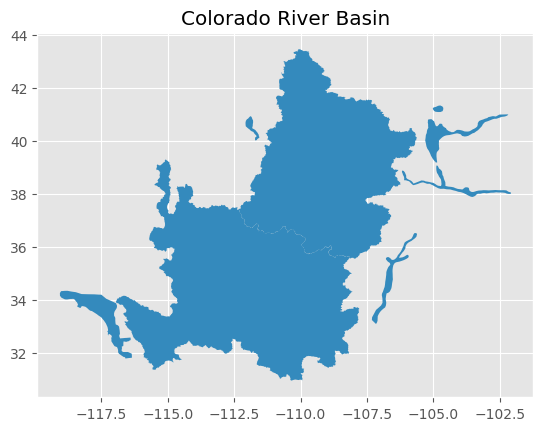

In [ ]:
# min/max of lat/long then go from there. 
import geopandas as gpd 
import matplotlib.pyplot as plt

shpfl = gpd.read_file("/home/kmk58/remoteData/shapefiles/Colorado_River_Basin_Hydrological_Boundaries_with_Areas_served_by_Colorado_River.shp")

# plot of entire Colorado River Basin
plt.style.use('ggplot')
plt.figure(figsize=[10,10])
shpfl.plot()
plt.title("Colorado River Basin")
plt.show()

As you can see from the output above, the shapefile is mapped with lattitude on the x-axis and longitude on the y-axis. We can easily discern the area of the Colorado River Basin. 

Our next step is to filter the GRACE and GLDAS data to the CRB region before merging and processing the data. There are a few steps involved with this: 

1. We must extract a list of latitude and longitude coordinates for the CRB 
2. We must filter GRACE down to points only contained in this file 
3. We must filter GLADS down to points only contained in this file. 

In [ ]:
# Code to filter to shapefile

,lon,lat,time,lwe_thickness,uncertainty,scale_factor
0,0.25,-89.75,2002-04-17 12:00:00,-4.017296,3.083626,NaN
1,0.25,-89.75,2002-05-10 12:00:00,-4.741868,1.810036,NaN
2,0.25,-89.75,2002-08-16 12:00:00,-3.809605,1.486383,NaN
3,0.25,-89.75,2002-09-16 00:00:00,-2.215605,1.741707,NaN
4,0.25,-89.75,2002-10-16 12:00:00,-2.167548,1.035635,NaN
...,...,...,...,...,...,...
57023995,359.75,89.75,2022-12-16 12:00:00,6.202807,0.455213,NaN
57023996,359.75,89.75,2023-01-16 12:00:00,3.390809,0.458894,NaN
57023997,359.75,89.75,2023-02-15 00:00:00,1.942351,0.467996,NaN
57023998,359.75,89.75,2023-03-16 12:00:00,3.728371,0.452308,NaN


First, since the data is an xarray dataset, we can do some processing to transform the dataset into a standard tabular, pandas dataframe. For efficiency, we can also only select the variables we need, and for use with other datasets, we will transform the longitude points from a [0,360] range to a [-180,180] range.  

In [16]:
# Need to figure out what to do about the NaNs

grace_df = grace[['lon','lat','time','lwe_thickness','uncertainty','scale_factor']].to_dataframe()
grace_df.reset_index(inplace=True)
grace_df.sort_values(by='time', inplace=True)
grace_df["lon"] = grace_df["lon"] - 180  # converting longitude points
grace_df['new_lwe'] = grace_df['lwe_thickness'] * grace_df['scale_factor']
grace_df

,lon,lat,time,lwe_thickness,uncertainty,scale_factor,new_lwe
0,-179.75,-89.75,2002-04-17 12:00:00,-4.017296,3.083626,NaN,NaN
39610560,70.25,-65.75,2002-04-17 12:00:00,-4.503871,2.598409,NaN,NaN
39610780,70.25,-65.25,2002-04-17 12:00:00,-4.503871,2.598409,NaN,NaN
39611000,70.25,-64.75,2002-04-17 12:00:00,-4.503871,2.598409,NaN,NaN
39611220,70.25,-64.25,2002-04-17 12:00:00,0.389394,5.878719,NaN,NaN
...,...,...,...,...,...,...,...
37842419,58.75,55.25,2023-04-16 00:00:00,-2.598308,7.996832,0.994096,-2.582968
37842199,58.75,54.75,2023-04-16 00:00:00,-2.598308,7.996832,1.108262,-2.879606
37841979,58.75,54.25,2023-04-16 00:00:00,-2.598308,7.996832,1.108262,-2.879606
37844839,58.75,60.75,2023-04-16 00:00:00,-12.443127,3.596378,0.792977,-9.867120


##### Upsampling GRACE

One key consideration for combining GRACE and GLDAS data is that pixels in GRACE data are .5°x.5° while GLDAS data has .25°x.25° pixels. One way to handle this is to "upscale" GRACE data to make it mergable with GLDAS. That is, transform the GRACE data pixels from .5°x.5° to .25°x.25°. 

One way we can do this is to "upsample" GRACE data. Essentially, we will 

This is shown visually below: 

Finally, we implement this in code: 

In [17]:
## also feel like we can do something to make this run faster. 

import collections
import pandas as pd

up_gr_df = pd.DataFrame()

for t in collections.Counter(grace_df["time"]).keys():
    
    sub_df_gr = grace_df[grace_df["time"] == t]
    #print(t)
    
    for x,y in zip(sub_df_gr["lon"], sub_df_gr["lat"]):
                
        xx = [round(x-0.125,3), round(x+0.125,3)] 
        yy = [round(y-0.125,3), round(y+0.125,3)]
        
        val_df = sub_df_gr[(sub_df_gr["lon"]==x)&(sub_df_gr["lat"]==y)]

        temp_df = pd.DataFrame()
                    
        temp_df["time"] = [t]*4
        temp_df["lon"] = [xx[0],xx[0],xx[1],xx[1]]
        temp_df["lat"] = [yy[0],yy[1],yy[0],yy[1]]
        temp_df["lwe_thickness"] = [val_df["lwe_thickness"].mean()]*4

        up_gr_df = pd.concat([up_gr_df,temp_df])

KeyboardInterrupt: 

 After "upsampling" the GRACE data, it now also has a .25° by .25° granularity. Each "pixel" thus represents a chunk of land approximately 235.46 miles squared ($\approx$ 378.94 kilometers squared). A visualizaiton of a pixel is shown below.

<p align="center">
    <img src="images/lon-lat.png" width="500" />
</p>

## Citations

(Sharma D, Patnaik S, Biswal B, Reager JT. Characterization of Basin-Scale Dynamic Storage–Discharge Relationship Using Daily GRACE Based Storage Anomaly Data. Geosciences. 2020; 10(10):404. https://doi.org/10.3390/geosciences10100404). 

Merging shapefiles in ArcGIS. (n.d.). Retrieved July 24, 2023, from https://www.restore.ac.uk/geo-refer/91010mwors01y00000000.php


